<a href="https://colab.research.google.com/github/PhataPoster/KNN-/blob/main/KNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [54]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.neighbors import KNeighborsClassifier

from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score, roc_auc_score,
    confusion_matrix, classification_report, roc_curve, auc
)

sns.set(style="whitegrid", context="notebook")
np.random.seed(42)

In [57]:
dataset_url = "https://raw.githubusercontent.com/PhataPoster/KNN-/main/diabetes.csv"
df = pd.read_csv(dataset_url)

print("Shape:", df.shape)
display(df.head())
print(df.info())
print("\nMissing values per column:\n", df.isna().sum())

Shape: (768, 9)


,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Pregnancies               768 non-null    int64  
 1   Glucose                   768 non-null    int64  
 2   BloodPressure             768 non-null    int64  
 3   SkinThickness             768 non-null    int64  
 4   Insulin                   768 non-null    int64  
 5   BMI                       768 non-null    float64
 6   DiabetesPedigreeFunction  768 non-null    float64
 7   Age                       768 non-null    int64  
 8   Outcome                   768 non-null    int64  
dtypes: float64(2), int64(7)
memory usage: 54.1 KB
None

Missing values per column:
 Pregnancies                 0
Glucose                     0
BloodPressure               0
SkinThickness               0
Insulin                     0
BMI                         0
DiabetesPedigreeFunction  

In [58]:
target_col = 'Outcome'
X = df.drop(columns=[target_col])
y = df[target_col]

print("Class distribution:\n", y.value_counts(normalize=True))

Class distribution:
 Outcome
0    0.651042
1    0.348958
Name: proportion, dtype: float64


In [59]:
# All columns (except Outcome) are numeric in this dataset
numeric_features = X.columns.tolist()
categorical_features = []  # no categorical columns here

print("Numeric features:", numeric_features)
print("Categorical features:", categorical_features)

numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

# Just in case there were categorical features (here it's empty)
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

transformers = [
    ('num', numeric_transformer, numeric_features),
]

if categorical_features:
    transformers.append(('cat', categorical_transformer, categorical_features))

preprocessor = ColumnTransformer(transformers=transformers)

Numeric features: ['Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI', 'DiabetesPedigreeFunction', 'Age']
Categorical features: []


In [60]:
# 15% test
X_train_val, X_test, y_train_val, y_test = train_test_split(
    X, y, test_size=0.15, random_state=42, stratify=y
)

# From remaining 85%, about 17.65% as validation -> overall ~15% val
X_train, X_val, y_train, y_val = train_test_split(
    X_train_val, y_train_val, test_size=0.1765, random_state=42, stratify=y_train_val
)

print("Train size     :", X_train.shape[0])
print("Validation size:", X_val.shape[0])
print("Test size      :", X_test.shape[0])

Train size     : 536
Validation size: 116
Test size      : 116


In [61]:
knn_clf = KNeighborsClassifier()

model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('knn', knn_clf)
])

param_grid = {
    'knn__n_neighbors': list(range(1, 31)),  # k = 1..30
    'knn__weights': ['uniform', 'distance'],
    'knn__metric': ['euclidean', 'manhattan', 'minkowski']
}

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

grid_search = GridSearchCV(
    estimator=model,
    param_grid=param_grid,
    cv=cv,
    scoring='accuracy',
    n_jobs=-1,
    verbose=1
)

grid_search.fit(X_train, y_train)

print("Best parameters:", grid_search.best_params_)
print("Best CV accuracy: {:.4f}".format(grid_search.best_score_))

best_model = grid_search.best_estimator_

Fitting 5 folds for each of 180 candidates, totalling 900 fits
Best parameters: {'knn__metric': 'manhattan', 'knn__n_neighbors': 25, 'knn__weights': 'distance'}
Best CV accuracy: 0.7668


In [62]:
# Validation accuracy (optional)
y_val_pred = best_model.predict(X_val)
val_acc = accuracy_score(y_val, y_val_pred)
print("Validation accuracy: {:.4f}".format(val_acc))

# Test predictions
y_pred = best_model.predict(X_test)
y_proba = best_model.predict_proba(X_test)[:, 1]

acc = accuracy_score(y_test, y_pred)
prec = precision_score(y_test, y_pred, zero_division=0)
rec = recall_score(y_test, y_pred, zero_division=0)
f1 = f1_score(y_test, y_pred, zero_division=0)
auc_score = roc_auc_score(y_test, y_proba)

print("\n=== Test Set Metrics ===")
print(f"Accuracy : {acc:.4f}")
print(f"Precision: {prec:.4f}")
print(f"Recall   : {rec:.4f}")
print(f"F1-score : {f1:.4f}")
print(f"AUC      : {auc_score:.4f}")

print("\nClassification Report:")
print(classification_report(y_test, y_pred, zero_division=0))

Validation accuracy: 0.7845

=== Test Set Metrics ===
Accuracy : 0.7845
Precision: 0.7586
Recall   : 0.5500
F1-score : 0.6377
AUC      : 0.8349

Classification Report:
              precision    recall  f1-score   support

           0       0.79      0.91      0.85        76
           1       0.76      0.55      0.64        40

    accuracy                           0.78       116
   macro avg       0.78      0.73      0.74       116
weighted avg       0.78      0.78      0.77       116



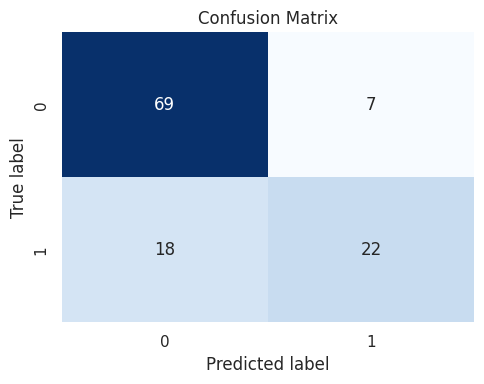

In [63]:
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(5, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.title('Confusion Matrix')
plt.tight_layout()
plt.show()

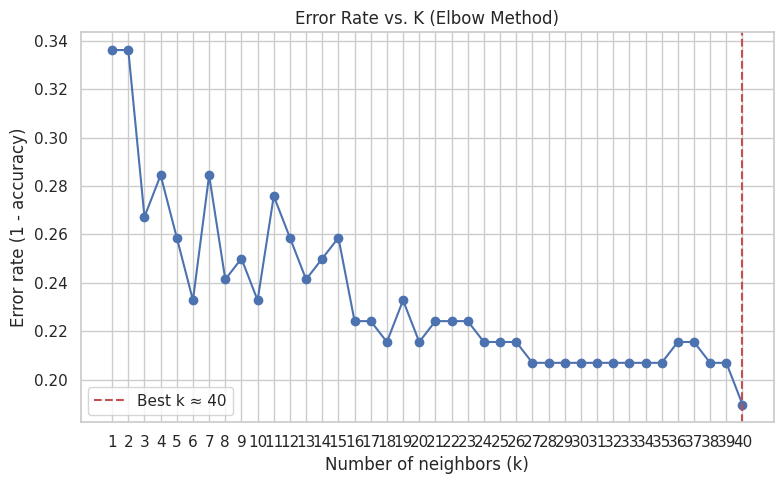

Approximate best k from elbow plot: 40


In [64]:
error_rates = []
k_values = range(1, 41)

best_weights = grid_search.best_params_['knn__weights']
best_metric = grid_search.best_params_['knn__metric']

for k in k_values:
    knn_temp = KNeighborsClassifier(
        n_neighbors=k,
        weights=best_weights,
        metric=best_metric
    )
    model_temp = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('knn', knn_temp)
    ])

    model_temp.fit(X_train, y_train)
    y_val_pred = model_temp.predict(X_val)
    error = 1 - accuracy_score(y_val, y_val_pred)
    error_rates.append(error)

best_k = k_values[int(np.argmin(error_rates))]

plt.figure(figsize=(8, 5))
plt.plot(k_values, error_rates, marker='o')
plt.xlabel('Number of neighbors (k)')
plt.ylabel('Error rate (1 - accuracy)')
plt.title('Error Rate vs. K (Elbow Method)')
plt.axvline(x=best_k, color='r', linestyle='--', label=f'Best k ≈ {best_k}')
plt.xticks(k_values)
plt.legend()
plt.tight_layout()
plt.show()

print("Approximate best k from elbow plot:", best_k)

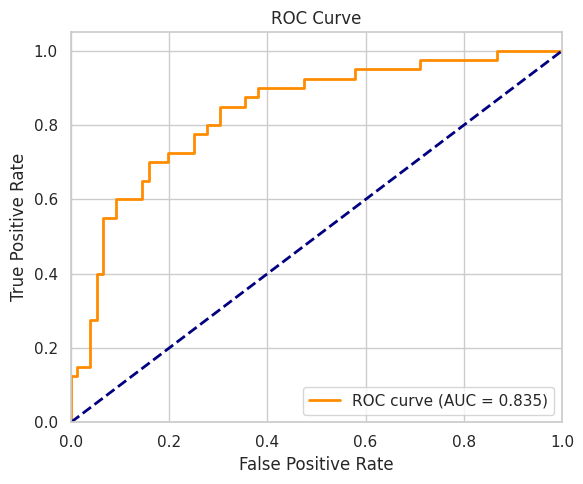

In [65]:
fpr, tpr, thresholds = roc_curve(y_test, y_proba)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(6, 5))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.3f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc="lower right")
plt.grid(True)
plt.tight_layout()
plt.show()

/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but SimpleImputer was fitted with feature names
  warnings.warn(


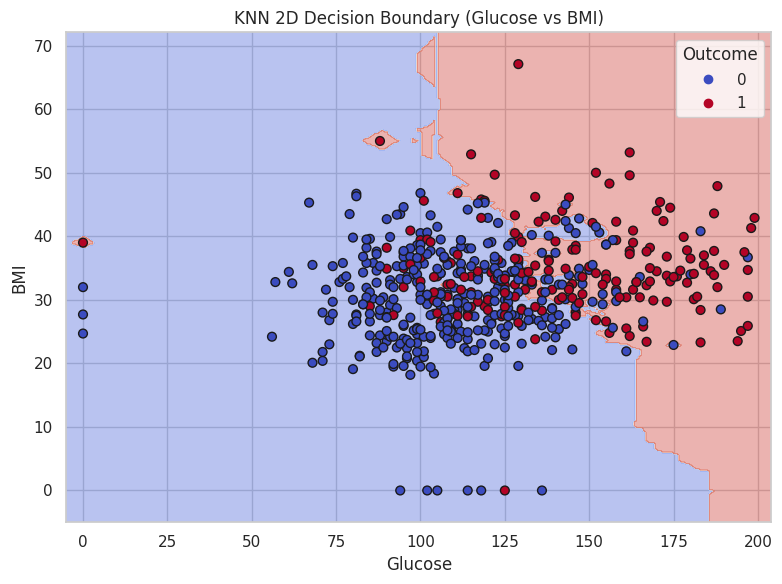

In [66]:
# 2D visualization using two numeric features
feature_x = 'Glucose'
feature_y = 'BMI'
features_2d = [feature_x, feature_y]

X_train_2d = X_train[features_2d]
X_test_2d = X_test[features_2d]

# Impute and scale for 2D subset
imputer_2d = SimpleImputer(strategy='median')
scaler_2d = StandardScaler()

X_train_2d_imputed = imputer_2d.fit_transform(X_train_2d)
X_train_2d_scaled = scaler_2d.fit_transform(X_train_2d_imputed)

X_test_2d_imputed = imputer_2d.transform(X_test_2d)
X_test_2d_scaled = scaler_2d.transform(X_test_2d_imputed)

# KNN with best hyperparameters
knn_2d = KNeighborsClassifier(
    n_neighbors=grid_search.best_params_['knn__n_neighbors'],
    weights=grid_search.best_params_['knn__weights'],
    metric=grid_search.best_params_['knn__metric']
)

knn_2d.fit(X_train_2d_scaled, y_train)

# Create mesh grid in original feature space
x_min, x_max = X[feature_x].min() - 5, X[feature_x].max() + 5
y_min, y_max = X[feature_y].min() - 5, X[feature_y].max() + 5

xx, yy = np.meshgrid(
    np.linspace(x_min, x_max, 300),
    np.linspace(y_min, y_max, 300)
)

grid_points = np.c_[xx.ravel(), yy.ravel()]

# Apply same imputer and scaler to grid points
grid_imputed = imputer_2d.transform(grid_points)
grid_scaled = scaler_2d.transform(grid_imputed)

Z = knn_2d.predict(grid_scaled)
Z = Z.reshape(xx.shape)

plt.figure(figsize=(8, 6))
# Decision regions
plt.contourf(xx, yy, Z, alpha=0.4, cmap=plt.cm.coolwarm)

# Training points
scatter = plt.scatter(
    X_train[feature_x], X_train[feature_y],
    c=y_train, cmap=plt.cm.coolwarm, edgecolor='k', s=40
)

plt.xlabel(feature_x)
plt.ylabel(feature_y)
plt.title('KNN 2D Decision Boundary (Glucose vs BMI)')
plt.legend(*scatter.legend_elements(), title="Outcome")
plt.tight_layout()
plt.show()